# XGBoost 

Ensemble learning methods, and in partiular boosted machines such as XGBoost, often provide SOTA performance on tabular data. If a time series can be compressed into tabular features, an ensemble method may enable prediction of price action by way of logistic regression.

Fortunately, "technical analysis" features and algorithms are well known in market analysis circles, and are in a sense the embodiment of the above condition. Another set of features comes from macro economic measures such as the volatility of the stock market and interest rates. Combined, this superset of features should give the model information about the specific time series of interest in addition to general market trends.

The features used in the original exploration for this model are:

**Technical Analysis**:
1. (RSI) relative strength indicator
2. Stochastic oscillator
3. (ADX) advance–decline line
4. (MACD) moving average cross-over divergence
5. (ROC) price rate of change
6. (OBV) on balance volume
7. (MFI) money flow index
8. (WAD) Williams accumulationand distribution
9. 50-day moving average
10. 200-day moving average

**Macro Economic**:

11. (EPU) economic policy uncertainty
12. Ten Year Bond Interest Rate
13. Three Month Treasury Bill Interest Rate
14. (EMU) Economic Market Uncertainty
15. Expected five year inflation
16. Infectious Disease Tracker (COVID 19)
17. (VIX) CBOE volatility index
18. (OVX) estimate of the expected volatility over the next thirty days
19. (CPI) Consumer price index
20. Fear and Greed Index


## Imports

In [1]:
import pandas_ta as ta
from datetime import date
from datetime import timedelta

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import xgboost as xgb
import seaborn as sns
import tensorflow as tf
import random as rand
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

from datetime import date
import dateutil.parser as du
from cryptocmd import CmcScraper

from fear_greed_index import CNNFearAndGreedIndex

## Functions

In [14]:
def uniform_date_range(df, s_date, e_date):
    #This function takes in a dataframe containing a column that is some variation of 'Date'
    #as well as a desired start and end date (datetime). It returns a dataframe whos index is the date range,
    #automatically filling in missing dates with values of 0
    
    # Get today's date
    today = date.today()
    # Yesterday date
    yesterday = today - timedelta(days = 1)
    idx = pd.date_range(s_date, e_date)
    #convert the date column to datetime
    if 'DATE' in df:
        df.index = pd.to_datetime(df['DATE'])
        #drop the date column
        df = df.drop(columns=['DATE'])
    else:
        pass
    
    df.index = pd.to_datetime(df.index).date
    #keep only dates after the specified date
    adj_df = df[df.index>=s_date].copy()
    adj_df = adj_df[adj_df.index<=e_date].copy()
    #fill missing dates
    adj_df = adj_df.reindex(idx, fill_value=0)
    
    return adj_df


def compute_price_action(data):
#takes data in the form of a 1-D numpy array containing the values (prices) of the time series
#outputs a numpy array containing strings describing the price action between the current step and future step
    p_actions = []
    for n in range(0,len(data)-1):
        if data[n+1] > data[n]:
            p_actions.append(1)
        elif data[n+1] < data[n]:
            p_actions.append(0)
        else:
            p_actions.append(0)
    p_actions = np.array(p_actions)
    return p_actions

## Feature Generation

In [15]:
#Compute the price actions (the target) for BTC. These are the ground truth indicators
#of whether the price will increase or decrease the following day
horizon = 2


#Get the earliest date in the BTC price DataFrame. This will be used to define the earliest date in the used dataset
start_dt = date(2014, 8, 1)

end_dt = date(2022, 9, 1)

today = date.today()
td = timedelta(days=2)

end_dt = today - td

#In order to offset the macro economic features from the specified horizon, a different time span is required
start_dt_X = start_dt - timedelta(days=horizon)
end_dt_X = end_dt

#In order to offset the price action from the specified horizon, a different time span is required
start_dt_y = start_dt
end_dt_y = end_dt + timedelta(days=horizon)

#In order to align the technical analysis features with the price action, different time span is required
start_dt_ta = start_dt - timedelta(days=1)
end_dt_ta = end_dt + timedelta(days=1)

#Scrape live bitcoin prices from coinmarketcap api
scraper = CmcScraper('BTC')
BTC_df = scraper.get_dataframe()

#rearrange BTC timeline earliest to latest
BTC_df = BTC_df.iloc[::-1]
BTC_df.reset_index(inplace=True, drop=True)

#Compute the price action series from the BTC close history
pa_df = compute_price_action(BTC_df['Close'])
print(pa_df[-15:])
orig_df = BTC_df.copy()

#Drop the most recent days datapoint for alignment with predictions
BTC_df = BTC_df.iloc[:-1 , :]

#create price action dataframe
pa_df = pd.DataFrame(pa_df, columns=['Price Action'])

#align price action index with bitcoin index (dates)
pa_df.index = BTC_df['Date']

#subtract the horizon from the back end of the price action (pa needs X amount of horizon before computing its first value)
pa_df = uniform_date_range(pa_df, start_dt_y, end_dt_y)


[0 1 1 0 0 1 0 0 1 1 1 1 1 1 0]


### Technical Analysis Derived Features

In [16]:
#Use the pandas_ta module to compute TA features using BTC features
rsi_df = ta.rsi(orig_df['Close'])
adx_df = ta.adx(orig_df['High'],orig_df['Low'],orig_df['Close'])
macd_df = ta.macd((orig_df['Close']))
roc_df = ta.roc((orig_df['Close']))
obv_df = ta.obv(orig_df['Close'],orig_df['Volume'])
mfi_df = ta.mfi(orig_df['High'],orig_df['Low'],orig_df['Close'],orig_df['Volume'])
stoch_df = ta.stoch(orig_df['High'],orig_df['Low'],orig_df['Close'])
wad_df = ta.ad(orig_df['High'],orig_df['Low'],orig_df['Close'],orig_df['Volume'])
ma50_df = ta.sma(orig_df['Close'], length=50)
ma200_df = ta.sma(orig_df['Close'], length=200)
ma7_df = ta.sma(orig_df['Close'], length=7)

#Concatenate all TA features into a single DataFrame
ta_df = pd.concat([rsi_df, adx_df, macd_df, roc_df, obv_df, mfi_df, stoch_df, wad_df], axis=1)

#Define the TA DataFrame index as that of the BTC price data dates
ta_df.index = orig_df['Date']

#fill NaNs with 0 values
ta_df = ta_df.fillna(0).copy()
ta_df = uniform_date_range(ta_df, start_dt_ta, end_dt_ta)

ta_df


,RSI_14,ADX_14,DMP_14,DMN_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,ROC_10,OBV,MFI_14,STOCHk_14_3_3,STOCHd_14_3_3,AD
2014-07-31,39.883201,31.468720,9.361655,39.629765,-9.504106,-4.947618,-4.556488,-5.781964,-2.227426e+08,30.249124,18.319941,14.896872,2.777458e+08
2014-08-01,44.836136,32.174081,15.135108,36.471027,-8.893209,-3.469377,-5.423832,-4.285249,-2.045267e+08,31.479090,28.109636,20.013170,2.882970e+08
2014-08-02,42.415798,32.829058,14.378334,34.647432,-8.758608,-2.667820,-6.090787,-4.856513,-2.128858e+08,27.220405,39.785775,28.738451,2.860065e+08
2014-08-03,41.269711,33.661231,13.729981,35.729140,-8.766089,-2.140241,-6.625848,-2.503927,-2.228038e+08,26.681350,40.918730,36.271380,2.893531e+08
2014-08-04,42.595002,34.078064,14.732452,33.967362,-8.503257,-1.501927,-7.001330,-2.047452,-2.129362e+08,32.129489,38.745093,39.816533,2.916113e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-09,54.782679,28.843444,26.446611,23.358522,-633.514210,109.701992,-743.216203,8.003024,1.446442e+12,44.996974,46.679041,23.854403,4.016012e+12
2022-09-10,56.784454,27.608717,27.910992,22.127863,-459.668275,226.838342,-686.506617,8.133643,1.483356e+12,52.748311,72.347461,44.494320,4.042974e+12
2022-09-11,57.386482,26.474606,27.065646,21.382156,-311.148676,300.286353,-611.435029,8.158715,1.517849e+12,59.195685,98.438357,72.488287,4.077222e+12
2022-09-12,61.318962,26.184851,31.142894,19.736691,-143.282952,374.521661,-517.804614,12.021557,1.568062e+12,61.080226,98.529386,89.771735,4.119171e+12


### Macro Economic Derived Features

In [18]:
import requests
path = r"C:\Users\jbkra\Desktop\Machine Learning\Bitcoin-timeseries\data\Macro Economic Data (Current)"
IDs = ['USEPUINDXD', 'VIXCLS', 'WLEMUINDXD', 'EXPINF5YR', 'OVXCLS',
 'CPILFESL', 'INFECTDISEMVTRACKD']
s_today = str(today)
url_list = []
for n in range(0,len(IDs)):
    ID = IDs[n]
    data_url = "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id="+ID+"&scale=left&cosd=2013-01-01&coed="+s_today+"&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Daily%2C%207-Day&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date="+s_today+"&revision_date="+s_today+"&nd=1985-01-01"
    url_list.append(data_url)


# imported the requests library

for n in range(0, len(url_list)):
    # URL of the image to be downloaded is defined as image_url
    r = requests.get(url_list[n]) # create HTTP response object
    r.status_code  
    # send a HTTP request to the server and save
    # the HTTP response in a response object called r
    with requests.Session() as s:
        download = s.get(url_list[n])

        decoded_content = download.content.decode('utf-8')

        cr = csv.reader(decoded_content.splitlines(), delimiter=',')

    crl = list(cr)
    dl_df = pd.DataFrame(crl[1:], columns=[crl[0][0],crl[0][1]])
    file_name = IDs[n]+'.csv'
    full_path = os.path.join(path, file_name)
    dl_df.to_csv(full_path)

    


In [19]:

#Import macro economic data
epu = pd.read_csv(os.path.join(path, 'USEPUINDXD.csv')).iloc[:,1:]
vix = pd.read_csv(os.path.join(path, 'VIXCLS.csv')).iloc[:,1:]
emu = pd.read_csv(os.path.join(path, 'WLEMUINDXD.csv')).iloc[:,1:]
fiveyrinf = pd.read_csv(os.path.join(path, 'EXPINF5YR.csv')).iloc[:,1:]
ovx = pd.read_csv(os.path.join(path, 'OVXCLS.csv')).iloc[:,1:]
cpi = pd.read_csv(os.path.join(path, 'CPILFESL.csv')).iloc[:,1:]
infdisease = pd.read_csv(os.path.join(path, 'INFECTDISEMVTRACKD.csv')).iloc[:,1:]


#Ensure that all DataFrames share a uniform index
epu = uniform_date_range(epu, start_dt, end_dt)
vix = uniform_date_range(vix, start_dt, end_dt)
emu = uniform_date_range(emu, start_dt, end_dt)
fiveyrinf = uniform_date_range(fiveyrinf, start_dt, end_dt)
ovx = uniform_date_range(ovx, start_dt, end_dt)
cpi = uniform_date_range(cpi, start_dt, end_dt)
infdisease = uniform_date_range(infdisease, start_dt, end_dt)

#Move date column to the index for BTC 
BTC_df.index = BTC_df['Date']

#Modify date range to align with other features
BTC_df = uniform_date_range(BTC_df, start_dt_X, end_dt_X)


pa_df.index = BTC_df.index

#Concatenate macro economic features into single DataFrame
macro_df = pd.concat([epu, vix, emu,fiveyrinf,ovx,infdisease, BTC_df['Close']], axis=1)

#Replace missing values with 0
macro_df = macro_df.replace(to_replace='.', value=0)

macro_ls = ['USEPUINDXD','VIXCLS','WLEMUINDXD','EXPINF5YR','OVXCLS']

#Fill zeros of the appropriate features
macro_df[macro_ls] = macro_df[macro_ls].replace(to_replace=0, method='ffill')

#Fill NaNs of all features
macro_df = macro_df.fillna(method='bfill')

# interest_rates = tenyrbnd - threemnthtbill

macro_df

,USEPUINDXD,VIXCLS,WLEMUINDXD,EXPINF5YR,OVXCLS,INFECTDISEMVTRACKD,Close
2014-07-30,53.10,17.03,16.36,1.766452,19.39,0.00,567.293030
2014-07-31,53.10,17.03,16.36,1.766452,19.39,0.00,586.234985
2014-08-01,53.10,17.03,16.36,1.766452,19.39,0.00,594.916016
2014-08-02,92.27,17.03,88.61,1.766452,19.39,0.00,589.333008
2014-08-03,91.65,17.03,62.77,1.766452,19.39,0.00,586.666016
...,...,...,...,...,...,...,...
2022-09-08,39.16,23.61,40.94,2.518709,51.29,8.16,19329.834933
2022-09-09,53.33,22.79,61.24,2.518709,48.84,4.33,21381.152855
2022-09-10,69.10,22.79,15.01,2.518709,48.84,6.46,21680.539413
2022-09-11,68.86,22.79,30.08,2.518709,48.84,18.04,21769.256340


<AxesSubplot:>

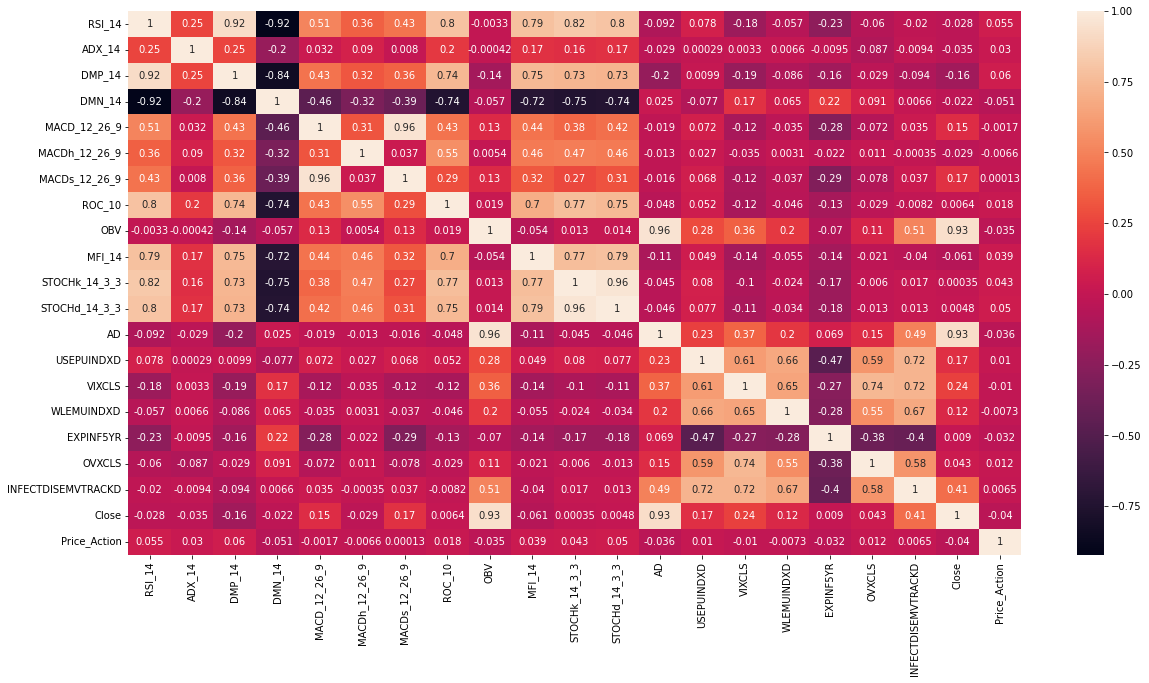

In [20]:
#Ensure alignment of technical analysis and macro economic dataframes
ta_df.index = macro_df.index

#Concatenate to form feature set
feature_df = pd.concat([ta_df,macro_df], axis=1)

#Convert feature datatypes to float
feature_df['VIXCLS'] = feature_df['VIXCLS'].astype('float64')
feature_df['OVXCLS'] = feature_df['OVXCLS'].astype('float64')


#Create seperate dataframe copy for heatmap
all_data = feature_df.copy()

#Append target values to heatmap dataframe
all_data['Price_Action'] = pa_df

# feature_df['AAA10Y'] = feature_df['AAA10Y'].astype('float64')
# feature_df['DTB3'] = feature_df['DTB3'].astype('float64')

#Create figure, plot heatmap
plt.figure(figsize=(20, 10))
data_corr = all_data.corr()
sns.heatmap(data_corr, annot=True)


In [21]:
#Drop rows equal to horizon to shave off dummy values in the feature dataframe
feature_df.drop(feature_df.tail(horizon).index, inplace=True)
pa_df.drop(pa_df.tail(horizon).index, inplace=True)

In [417]:
# from sklearn.preprocessing import StandardScaler
# feature_df = StandardScaler().fit_transform(feature_df)

# pca = PCA(n_components=5)
# principle_components = pca.fit_transform(feature_df)
# print(pca.explained_variance_ratio_)
# feature_df = pd.DataFrame(principle_components)
# feature_df

In [22]:
#Select either random sample of data or serial based sample of the data
train_strat = "random"
#Fraction of the dataset to use for test
test_size = .01

if train_strat == "random":
    
    X_train, X_test, y_train, y_test = train_test_split(feature_df, pa_df, test_size=test_size, random_state=30)
    
elif train_strat == "serial":
    train_frac = 1-test_size
    X_train = feature_df[:int(train_frac*len(feature_df))]
    X_test = feature_df[int(train_frac*len(feature_df)):]
    y_train = pa_df[:int(train_frac*len(feature_df))]
    y_test = pa_df[int(train_frac*len(feature_df)):]
else:
    print("Invalid Selection")

#Create eval set for model to evaluate against 
evalset = [(X_train, y_train), (X_test, y_test)]

## Model Definition and Training

In [420]:

param_grid = {
    "max_depth": [10],
    "learning_rate": [.0001],
    "gamma": [4],
    "reg_lambda": [4],
    "scale_pos_weight": [1],
    "subsample": [.3],
    "colsample_bytree": [.3],
    "n_estimators": [2000],
}
# param_grid = {
#     "max_depth": [10,20],
#     "learning_rate": [.00001],
#     "gamma": [3,4],
#     "reg_lambda": [3],
#     "scale_pos_weight": [1],
#     "subsample": [.2],
#     "colsample_bytree": [.3],
#     "n_estimators": [50],
# }

xgb_class = xgb.XGBClassifier(objective="binary:logistic")

grid_cv = GridSearchCV(xgb_class, param_grid, n_jobs=-1,scoring="roc_auc")

_ = grid_cv.fit(X_train, y_train,eval_set=eval_set,eval_metric="error",early_stopping_rounds=100,verbose=False)

print(grid_cv.best_score_)

# # Fit

preds = grid_cv.predict(X_test)

print(grid_cv.best_params_)

C:\Users\jbkra\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\jbkra\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


0.5198346133402147
{'colsample_bytree': 0.3, 'gamma': 4, 'learning_rate': 0.0001, 'max_depth': 10, 'n_estimators': 2000, 'reg_lambda': 4, 'scale_pos_weight': 1, 'subsample': 0.3}


## Save Model

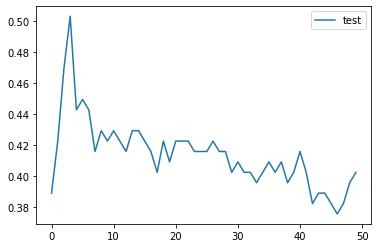

In [421]:
param_grid = {
    "max_depth": 10,
    "learning_rate": .00001,
    "gamma": 4,
    "reg_lambda": 4,
    "scale_pos_weight": 1,
    "subsample": .3,
    "colsample_bytree": .3,
    "n_estimators": 50,
}

xgb_class = xgb.XGBClassifier(objective="binary:logistic", **param_grid)
xgb_class.fit(X_train, y_train,eval_set=eval_set,eval_metric="error",early_stopping_rounds=100,verbose=False)
save_path = r"C:\Users\jbkra\Desktop\Machine Learning\Bitcoin-timeseries\models"
today_d = date.today()
today_s = today_d.strftime("%m_%d_%Y")
file_name = 'current_best_' + str(horizon)+ '_' + today_s + '.json'
full_path = os.path.join(save_path, file_name)
xgb_class.save_model(full_path)

results = xgb_class.evals_result()

# plot learning curves
plt.plot(results['validation_0']['error'], label='test')

# show the legend
plt.legend()
# show the plot
plt.show()

## Eval Metrics

### Accuracy, Precision, Recall, and F1 Scores

In [422]:
pred_test = grid_cv.predict(X_test)
pred_train = grid_cv.predict(X_train)

# # Score
test_acc = accuracy_score(y_test, pred_test)
test_prec = precision_score(y_test, pred_test)
test_rec = recall_score(y_test, pred_test)
test_f1 = f1_score(y_test, pred_test)
# # Score
train_acc = accuracy_score(y_train, pred_train)
print('The accuracy of this model on the training set is: ', "{:.1f}".format(100*train_acc), '%')
print('The accuracy of this model on the test set is: ', "{:.1f}".format(100*test_acc), '%')
print('The precision of this model on the test set is: ', "{:.1f}".format(100*test_prec), '%')




The accuracy of this model on the training set is:  66.4 %
The accuracy of this model on the test set is:  66.7 %
The precision of this model on the test set is:  70.8 %


### Accuracy on Very Recent Data

In [423]:
frac = .99
val_df = feature_df[int(frac*len(feature_df)):]
val_pa = pa_df[int(frac*len(pa_df)):]

val_predictions = grid_cv.predict(val_df)

val_len = len(val_df)

val_accuracy = accuracy_score(val_pa, val_predictions)
print("Accuracy over the previous", val_len, "days: ", val_accuracy)


Accuracy over the previous 30 days:  0.7666666666666667


### Accuracy on Total Data

In [424]:
total_predictions = grid_cv.predict(feature_df)

# # Score
val_accuracy = accuracy_score(pa_df, total_predictions)
print("Accuracy over entire data set: ", val_accuracy)

Accuracy over entire data set:  0.6639676113360324


### Confusion Matrices

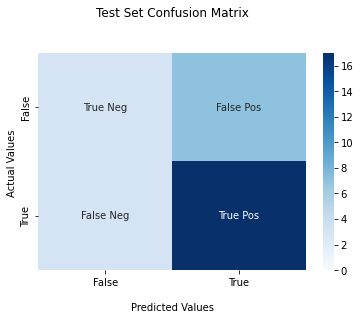

0.5
0.7083333333333334


In [425]:
conf_mat = confusion_matrix(y_test,pred_test)


labels = ['True Neg','False Pos','False Neg','True Pos']

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(conf_mat, annot=labels, fmt='', cmap='Blues', vmin = 0)

ax.set_title('Test Set Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()


tn = conf_mat[0,0]
fn = conf_mat[1,0]
tp = conf_mat[1,1]
fp = conf_mat[0,1]


print(tn/(tn+fn))
print(tp/(tp+fp))


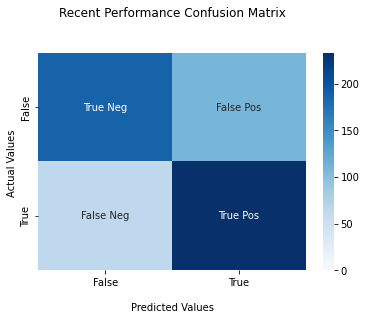

0.748
0.6793002915451894
            Price Action
2022-08-21             0
2022-08-22             1
2022-08-23             0
2022-08-24             0
2022-08-25             0
2022-08-26             1
2022-08-27             0
2022-08-28             1
2022-08-29             1
2022-08-30             0
2022-08-31             0
2022-09-01             1
2022-09-02             0
2022-09-03             0
2022-09-04             1
2022-09-05             1
2022-09-06             1
2022-09-07             1
2022-09-08             1
2022-09-09             1
[1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1
 0 1 1 1 0 1 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 1 1 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1


In [426]:
frac = .8
val_df = feature_df[int(frac*len(feature_df)):]
val_pa = pa_df[int(frac*len(pa_df)):]

val_predictions = grid_cv.predict(val_df)


conf_mat = confusion_matrix(val_pa ,val_predictions)


labels = ['True Neg','False Pos','False Neg','True Pos']

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(conf_mat, annot=labels, fmt='', cmap='Blues', vmin = 0)

ax.set_title('Recent Performance Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

tn = conf_mat[0,0]
fn = conf_mat[1,0]
tp = conf_mat[1,1]
fp = conf_mat[0,1]


print(tn/(tn+fn))
print(tp/(tp+fp))

print(val_pa.tail(20))
print(val_predictions)
print(orig_df[['Date','Close']])
print(feature_df['Close'])

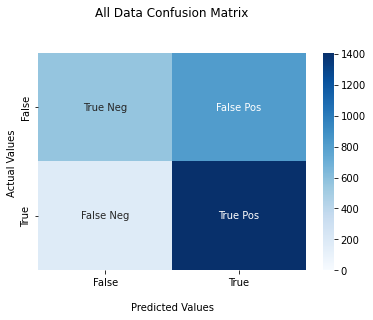

0.7588075880758808
0.6325247079964061


In [427]:
conf_mat = confusion_matrix(pa_df, total_predictions)


labels = ['True Neg','False Pos','False Neg','True Pos']

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(conf_mat, annot=labels, fmt='', cmap='Blues', vmin = 0)

ax.set_title('All Data Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

tn = conf_mat[0,0]
fn = conf_mat[1,0]
tp = conf_mat[1,1]
fp = conf_mat[0,1]


print(tn/(tn+fn))
print(tp/(tp+fp))

### Feature Importances

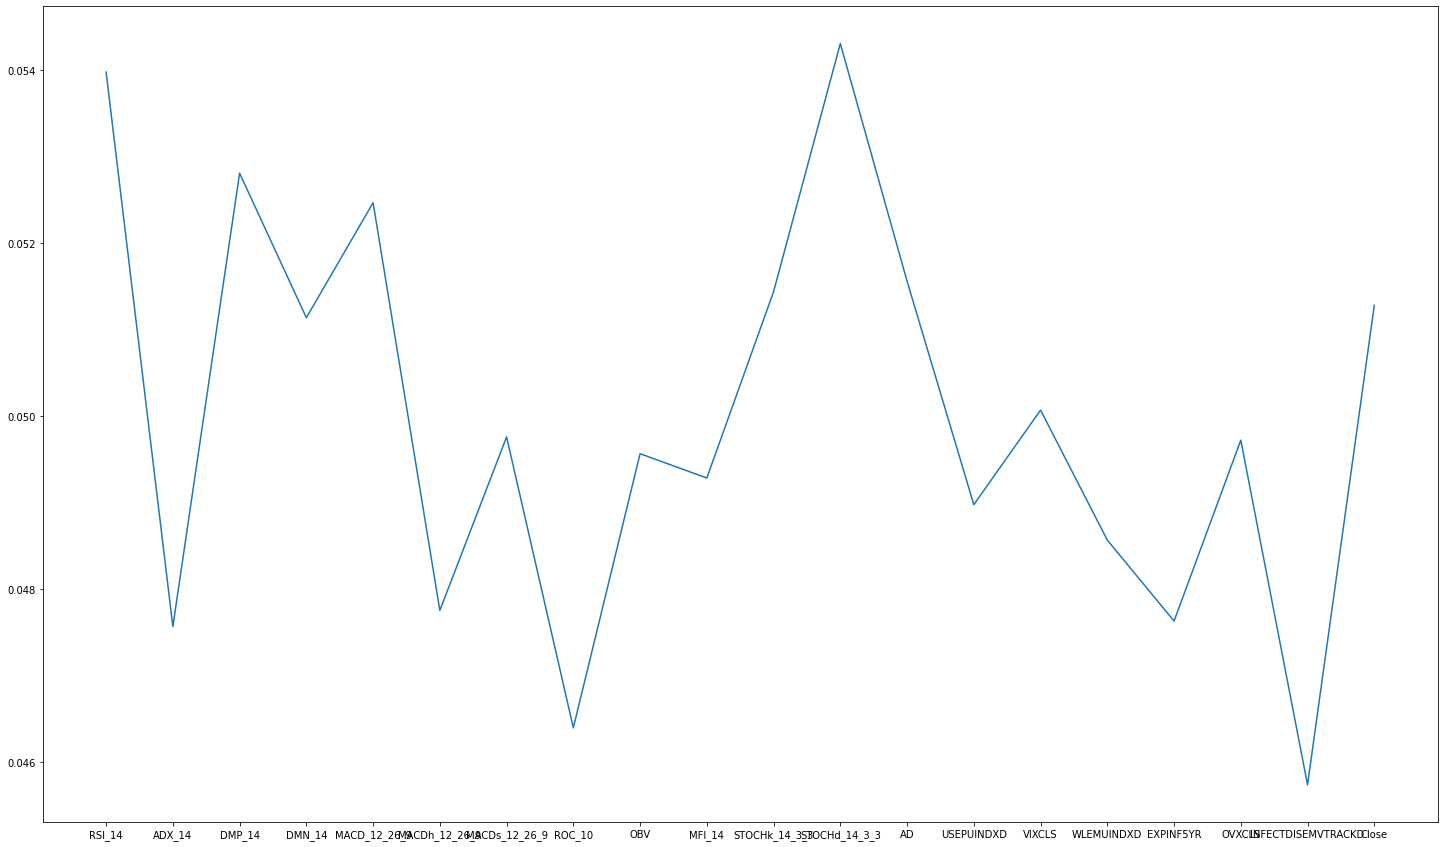

True    20
dtype: int64
                           0
RSI_14              0.053979
ADX_14              0.047565
DMP_14              0.052810
DMN_14              0.051138
MACD_12_26_9        0.052468
MACDh_12_26_9       0.047752
MACDs_12_26_9       0.049759
ROC_10              0.046394
OBV                 0.049565
MFI_14              0.049284
STOCHk_14_3_3       0.051439
STOCHd_14_3_3       0.054309
AD                  0.051561
USEPUINDXD          0.048975
VIXCLS              0.050069
WLEMUINDXD          0.048566
EXPINF5YR           0.047629
OVXCLS              0.049721
INFECTDISEMVTRACKD  0.045734
Close               0.051281


In [428]:
feature_imps = pd.DataFrame(grid_cv.best_estimator_.feature_importances_, X_train.columns)
# feature_imps = feature_imps.sort_values(by=feature_imps.columns[0],axis=1)
plt.figure(figsize=(25, 15))
plt.plot(feature_imps)
plt.show()
keep = 100*feature_imps > 4
print(keep.value_counts())
print(feature_imps)

In [429]:
['WLEMUINDXD', 'Close','DMP_14', 'MACDs_12_26_9', 'AD', 'SMA_50', 'SMA_200', 'SMA_7', 'EXPINF5YR']

['WLEMUINDXD',
 'Close',
 'DMP_14',
 'MACDs_12_26_9',
 'AD',
 'SMA_50',
 'SMA_200',
 'SMA_7',
 'EXPINF5YR']

### Correct vs Incorrect Predictions on Timeline

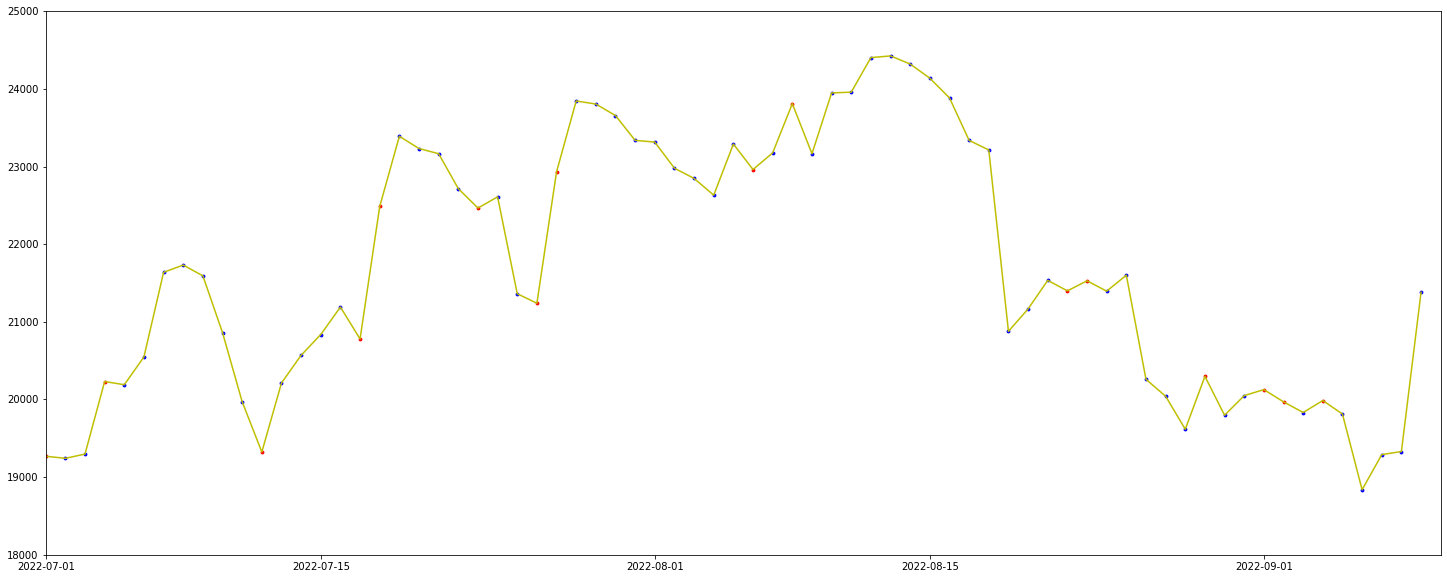

In [439]:
plt.figure(figsize=(25, 10))
rights = []
idxs = []
idxs2 = []
wrongs = []


for n in range(0,len(pa_df)-2):
    if pa_df.iloc[n,:].values == total_predictions[n]:
        rights.append(feature_df['Close'].iloc[n+2])
        idxs.append(feature_df.index[n+2])
    else:
        wrongs.append(feature_df['Close'].iloc[n+2])
        idxs2.append(feature_df.index[n+2])
        
graph_df = feature_df.copy()
graph_df.index = pa_df.index

plt.plot(graph_df['Close'], color='y')
plt.scatter(idxs2, wrongs, color='r',s=8)
plt.scatter(idxs, rights, color='b',s=8)   
# plt.xlim([datetime.datetime(2021, 1, 28, 0, 0, 0),datetime.datetime(2022, 1, 28, 0, 0, 0)])
plt.xlim([date(2022, 7, 1),date(2022, 9, 10)])
plt.ylim([18000,25000])
plt.show()

# Trading Strategies

## Functions

In [494]:
def trading_strat_Model(actions, prices, t_frac, horizon, fee):
    USDs = []
    USD = 100
    BTC = USD/prices[0]
    for n in range(0,len(prices)-horizon):
        if actions[n] == 1:
            t_amount = USD*t_frac
            USD = USD - t_amount
            BTC = BTC + t_amount*(1-fee)/prices[n+horizon]
        elif actions[n] == 0:
            t_amount = BTC*t_frac
            BTC = BTC - t_amount
            USD = USD + prices[n+horizon]*t_amount*(1-fee)
        else:
            pass
        USDs.append(USD + (prices[n+horizon]*BTC))
    earnings = (prices[-1]*BTC) + USD
    USDs = np.array(USDs)
    USDs = USDs
    plt.plot(USDs)
    return earnings

def trading_strat_HODL(prices):
    USDs = []
    USD = 100
    BTC = USD/prices[0]
    t_frac = 1
    t_amount = USD*t_frac
    USD = USD - t_amount
    BTC = BTC + t_amount/prices[0]
    for n in range(0,len(prices)):
        USDs.append(USD + (prices[n]*BTC))
    earnings = (prices[-1]*BTC) + USD
    USDs = np.array(USDs)
    plt.plot(USDs[2:])
    return earnings

## Lifetime Trade Prediction

Total profit from using Ensemble Model with DCA: $ 42149892.91
Total profit from using HODL Method: $ 7337.96
An average of  14220.6116  per day


Text(0.5, 1.0, 'Model Returns vs. HODL Returns')

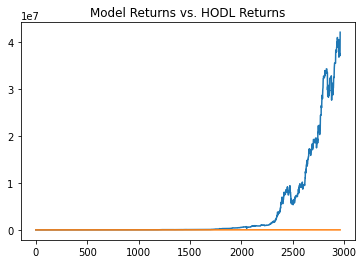

In [495]:
fee = .001
total_predictions = xgb_class.predict(feature_df)

num_days = len(total_predictions)
dca_profit = trading_strat_Model(total_predictions, feature_df['Close'], 1, horizon, fee)
hodl_profit = trading_strat_HODL(feature_df['Close'])

print("Total profit from using Ensemble Model with DCA: $", "{:.2f}".format(dca_profit-200))
print("Total profit from using HODL Method: $", "{:.2f}".format(hodl_profit-200))

print("An average of ","{:.4f}".format((dca_profit-200)/num_days)," per day")
plt.title('Model Returns vs. HODL Returns')

In [496]:
day_perc = ((dca_profit - 200)/200)/len(mod_prices)
print(day_perc*100*365)

256411848.53259033


## Partial-Lifetime Trade Prediction

C:\Users\jbkra\AppData\Local\Temp\ipykernel_3248\1435093601.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mod_prices = closes[np.int(life_frac*len(closes)):].copy()


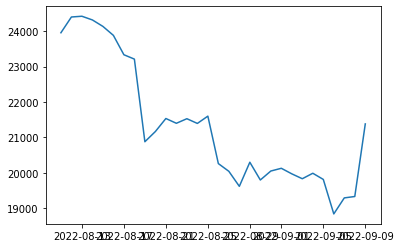

In [514]:
life_frac = .99
mod_predictions = total_predictions[int(life_frac*len(total_predictions)):].copy()
mod_tru = pa_df[int(life_frac*len(pa_df)):].copy()
closes = feature_df['Close'].copy()
mod_prices = closes[np.int(life_frac*len(closes)):].copy()
plt.plot(mod_prices)


Total profit from using Ensemble Model with DCA: $ 7.37
Total profit from using HODL Method: $ -21.51
[0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0]


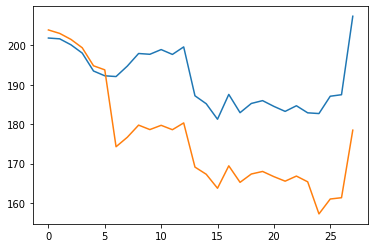

In [515]:
model_profit = trading_strat_Model(mod_predictions, mod_prices, 1,horizon,fee)
hodl_profit = trading_strat_HODL(mod_prices)
# tru_profit = trading_strat_Model(mod_tru, mod_prices, 1,horizon,fee)

print("Total profit from using Ensemble Model with DCA: $", "{:.2f}".format(model_profit-200))
print("Total profit from using HODL Method: $", "{:.2f}".format(hodl_profit-200))
print(mod_predictions)

In [516]:
day_perc = ((model_profit - 200)/200)/len(mod_prices)
print(day_perc*100*365)

44.84127260237804


Whole Life:
next day lag: 631450.79(3832.18)
2 day lag: 17872.11 (3739.74)

5% Life:
next day lag: 14.54 (-63.23)
2 day lag: -34.92(-63.23)

# Daily Prediction with Selected Model

## Imports

In [1]:
import pandas_ta as ta
from datetime import timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import xgboost as xgb
import seaborn as sns
import tensorflow as tf
import random as rand

from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# importlib.reload(cryptocmd)
from cryptocmd import CmcScraper

from datetime import date
from datetime import datetime
import dateutil.parser as du
import os


## Setup

In [2]:
#Used to determine whether to load a pre-existing model or train a new one
mode = "Load"

In [3]:
#Define the horizon
horizon = 2
today = date.today()
tomorrow = today + timedelta(days = 1)
#Define the timeline of interest. If the horizon is 1 day, you want to look at yesterdays data to predict
#tomorrows price action
start_dt = date(2017, 1, 1)



In [4]:
#New close data comes in at 5 PM PST daily. If it is before this time on the current day, use only the previous days close

nw = datetime.now()
tdy = datetime.combine(today, datetime.min.time())
td = timedelta(hours = 17)
info_td = timedelta(hours = 8)
info_time = tdy + info_td
close_time = tdy + td
comp = nw < close_time
comp2 = nw > info_time
if comp == True and comp2 == True:
    end_dt = today - timedelta(days = 2)
    start_dt = start_dt - timedelta(days=2)
else:
    end_dt = today - timedelta(days = 1)


## Functions

In [5]:
def uniform_date_range(df, s_date, e_date):
    #This function takes in a dataframe containing a column that is some variation of 'Date'
    #as well as a desired start and end date (datetime). It returns a dataframe whos index is the date range,
    #automatically filling in missing dates with values of 0
    
    # Get today's date
    today = date.today()
    # Yesterday date
    yesterday = today - timedelta(days = 1)
    idx = pd.date_range(s_date, e_date)
    #convert the date column to datetime
    if 'DATE' in df:
        df.index = pd.to_datetime(df['DATE'])
        #drop the date column
        df = df.drop(columns=['DATE'])
    else:
        pass
    
    df.index = pd.to_datetime(df.index).date
    #keep only dates after the specified date
    adj_df = df[df.index>=s_date].copy()
    adj_df = adj_df[adj_df.index<=e_date].copy()

    #fill missing dates
    adj_df = adj_df.reindex(idx, fill_value=0)
    return adj_df

def compute_price_action(data):
#takes data in the form of a 1-D numpy array containing the values (prices) of the time series
#outputs a numpy array containing strings describing the price action between the current step and future step
    p_actions = []
    for n in range(0,len(data)-1):
        if data[n+1] > data[n]:
            p_actions.append(1)
        elif data[n+1] < data[n]:
            p_actions.append(0)
        else:
            p_actions.append(0)
    p_actions = np.array(p_actions)
    return p_actions

## Web Scraping

### BTC Data

In [6]:
scraper = CmcScraper('BTC', end_date=today)
BTC_df = scraper.get_dataframe(forced=True)
#rearrange BTC timeline earliest to latest
BTC_df = BTC_df.iloc[::-1]
BTC_df.reset_index(inplace=True, drop=True)
print('Most recent close price was: ',BTC_df['Close'].iloc[-1], 'as of ', BTC_df['Date'].iloc[-1] )
BTC_df.index = BTC_df['Date']


# pa_df = compute_price_action(BTC_df['Close'])
BTC_df

Most recent close price was:  18937.01117567154 as of  2022-09-24 00:00:00


,Date,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,,
2013-04-28,2013-04-28,135.300003,135.979996,132.100006,134.210007,0.000000e+00,1.488567e+09
2013-04-29,2013-04-29,134.444000,147.488007,134.000000,144.539993,0.000000e+00,1.603769e+09
2013-04-30,2013-04-30,144.000000,146.929993,134.050003,139.000000,0.000000e+00,1.542813e+09
2013-05-01,2013-05-01,139.000000,139.889999,107.720001,116.989998,0.000000e+00,1.298955e+09
2013-05-02,2013-05-02,116.379997,125.599998,92.281898,105.209999,0.000000e+00,1.168517e+09
...,...,...,...,...,...,...,...
2022-09-20,2022-09-20,19545.591275,19602.456746,18813.455011,18890.789096,3.679135e+10,3.618764e+11
2022-09-21,2022-09-21,18891.282890,19674.630331,18290.315188,18547.399760,4.636379e+10,3.553149e+11
2022-09-22,2022-09-22,18534.649595,19456.910901,18415.591497,19413.551621,4.113577e+10,3.719240e+11


### Macro Economic Data

In [7]:
import requests
path = r"C:\Users\jbkra\Desktop\Machine Learning\Bitcoin-timeseries\data\Macro Economic Data (Current)"
IDs = ['USEPUINDXD', 'VIXCLS', 'WLEMUINDXD', 'EXPINF5YR', 'OVXCLS',
 'CPILFESL', 'INFECTDISEMVTRACKD']
s_today = str(today)
url_list = []
for n in range(0,len(IDs)):
    ID = IDs[n]
    data_url = "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id="+ID+"&scale=left&cosd=2013-01-01&coed="+s_today+"&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Daily%2C%207-Day&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date="+s_today+"&revision_date="+s_today+"&nd=1985-01-01"
    url_list.append(data_url)


# imported the requests library

for n in range(0, len(url_list)):
    # URL of the image to be downloaded is defined as image_url
    r = requests.get(url_list[n]) # create HTTP response object
    r.status_code  
    # send a HTTP request to the server and save
    # the HTTP response in a response object called r
    with requests.Session() as s:
        download = s.get(url_list[n])

        decoded_content = download.content.decode('utf-8')

        cr = csv.reader(decoded_content.splitlines(), delimiter=',')

    crl = list(cr)
    dl_df = pd.DataFrame(crl[1:], columns=[crl[0][0],crl[0][1]])
    file_name = IDs[n]+'.csv'
    full_path = os.path.join(path, file_name)
    dl_df.to_csv(full_path)

    


## Calculate TA features

In [8]:
#Use the pandas_ta module to compute TA features using BTC features
rsi_df = ta.rsi(BTC_df['Close'])
adx_df = ta.adx(BTC_df['High'],BTC_df['Low'],BTC_df['Close'])
macd_df = ta.macd((BTC_df['Close']))
roc_df = ta.roc((BTC_df['Close']))
obv_df = ta.obv(BTC_df['Close'],BTC_df['Volume'])
mfi_df = ta.mfi(BTC_df['High'],BTC_df['Low'],BTC_df['Close'],BTC_df['Volume'])
stoch_df = ta.stoch(BTC_df['High'],BTC_df['Low'],BTC_df['Close'])
wad_df = ta.ad(BTC_df['High'],BTC_df['Low'],BTC_df['Close'],BTC_df['Volume'])
ma50_df = ta.sma(BTC_df['Close'], length=50)
ma200_df = ta.sma(BTC_df['Close'], length=200)
ma7_df = ta.sma(BTC_df['Close'], length=7)

#Concatenate all TA features into a single DataFrame
ta_df = pd.concat([rsi_df, adx_df, macd_df, roc_df, obv_df, mfi_df, stoch_df, wad_df], axis=1)
#Defin the TA DataFrame index as that of the BTC price data dates
ta_df.index = BTC_df['Date']
#fill NaNs with 0 values
ta_df = ta_df.fillna(0).copy()

ta_df = uniform_date_range(ta_df, start_dt, end_dt)

ta_df


,RSI_14,ADX_14,DMP_14,DMN_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,ROC_10,OBV,MFI_14,STOCHk_14_3_3,STOCHd_14_3_3,AD
2017-01-01,83.082608,52.869949,51.424195,11.214427,56.481588,10.465832,46.015756,15.474708,5.026152e+09,78.950576,93.416834,94.168230,5.911082e+09
2017-01-02,84.885948,53.995430,54.378064,10.117144,59.783338,11.014066,48.769272,10.820794,5.248337e+09,80.534253,95.188900,93.928781,6.009774e+09
2017-01-03,86.362287,55.166906,54.510506,9.470429,63.451050,11.745422,51.705628,16.134222,5.433505e+09,81.475127,97.882845,95.496193,6.190989e+09
2017-01-04,91.075173,57.006830,66.347792,6.994732,74.447452,18.193459,56.253993,28.849800,5.778451e+09,83.325859,98.147186,97.072977,6.507803e+09
2017-01-05,61.771523,54.735730,39.406678,23.537539,70.938681,11.747751,59.190930,11.653686,5.268252e+09,67.351462,81.462846,92.497625,6.371917e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-19,42.190600,21.597996,19.256858,34.994123,-385.772534,-27.918085,-357.854449,-8.591789,1.506712e+12,44.128477,27.659540,28.672198,4.103685e+12
2022-09-20,38.230488,22.127300,17.958850,32.635344,-454.898359,-77.635128,-377.263231,-12.867532,1.469921e+12,44.678818,19.284886,24.985913,4.074106e+12
2022-09-21,36.301841,23.059281,15.930002,33.217734,-531.265623,-123.201914,-408.063709,-14.800031,1.423557e+12,43.860219,14.828217,20.590881,4.044963e+12
2022-09-22,43.978768,23.924692,14.594361,30.432614,-515.948481,-86.307817,-429.640663,-13.217871,1.464693e+12,44.697773,14.390886,16.167996,4.082673e+12


## Obtain Macro Economic Features

In [9]:

#Import macro economic data
epu = pd.read_csv(os.path.join(path, 'USEPUINDXD.csv')).iloc[:,1:]
vix = pd.read_csv(os.path.join(path, 'VIXCLS.csv')).iloc[:,1:]
emu = pd.read_csv(os.path.join(path, 'WLEMUINDXD.csv')).iloc[:,1:]
fiveyrinf = pd.read_csv(os.path.join(path, 'EXPINF5YR.csv')).iloc[:,1:]
ovx = pd.read_csv(os.path.join(path, 'OVXCLS.csv')).iloc[:,1:]
cpi = pd.read_csv(os.path.join(path, 'CPILFESL.csv')).iloc[:,1:]
infdisease = pd.read_csv(os.path.join(path, 'INFECTDISEMVTRACKD.csv')).iloc[:,1:]


#Ensure that all DataFrames share a uniform index
epu = uniform_date_range(epu, start_dt, end_dt)
vix = uniform_date_range(vix, start_dt, end_dt)
emu = uniform_date_range(emu, start_dt, end_dt)
fiveyrinf = uniform_date_range(fiveyrinf, start_dt, end_dt)
ovx = uniform_date_range(ovx, start_dt, end_dt)
cpi = uniform_date_range(cpi, start_dt, end_dt)
infdisease = uniform_date_range(infdisease, start_dt, end_dt)

BTC_df = uniform_date_range(BTC_df, start_dt, end_dt)

macro_df = pd.concat([epu, vix, emu,fiveyrinf,ovx, infdisease, BTC_df['Close']], axis=1)

macro_df = macro_df.replace(to_replace='.', value=0)
macro_ls = ['USEPUINDXD','VIXCLS','WLEMUINDXD','EXPINF5YR','OVXCLS']
macro_df[macro_ls] = macro_df[macro_ls].replace(to_replace=0, method='ffill')
# interest_rates = tenyrbnd - threemnthtbill

macro_df

,USEPUINDXD,VIXCLS,WLEMUINDXD,EXPINF5YR,OVXCLS,INFECTDISEMVTRACKD,Close
2017-01-01,235.10,0,170.26,1.845463,0,0.62,998.325012
2017-01-02,242.04,0,15.89,1.845463,0,0.00,1021.750000
2017-01-03,89.85,12.85,24.40,1.845463,32.88,0.48,1043.839966
2017-01-04,101.99,11.85,17.46,1.845463,32.36,0.00,1154.729980
2017-01-05,134.47,11.67,84.05,1.845463,31.56,0.00,1013.380005
...,...,...,...,...,...,...,...
2022-09-19,67.17,25.76,29.39,2.518709,46.75,13.79,19544.129250
2022-09-20,78.16,27.16,68.40,2.518709,48.23,10.72,18890.789096
2022-09-21,83.80,27.99,114.37,2.518709,48.65,14.56,18547.399760
2022-09-22,128.79,27.35,186.55,2.518709,47.1,14.75,19413.551621


## Combine Features

In [10]:
ta_df.index = macro_df.index

feature_df = pd.concat([ta_df,macro_df], axis=1)


feature_df['VIXCLS'] = feature_df['VIXCLS'].astype('float64')
feature_df['OVXCLS'] = feature_df['OVXCLS'].astype('float64')
# feature_df['fng_value'] = feature_df['fng_value'].astype('float64')

## Load/Train Model

In [11]:

# xgb_class.save_model(full_path)
full_path = r"C:\Users\jbkra\Desktop\Machine Learning\Bitcoin-timeseries\models\XBG_model_hor2_09_08_2022.json"
full_path = r"C:\Users\jbkra\Desktop\Machine Learning\Bitcoin-timeseries\models\ser_all_data_XBG_model_hor2_09_08_2022.json"
full_path = r"C:\Users\jbkra\Desktop\Machine Learning\Bitcoin-timeseries\models\current_best_2_09_13_2022.json"
# full_path2 = r"C:\Users\jbkra\Desktop\Machine Learning\Bitcoin-timeseries\models\best_all_data_XBG_model_hor2_09_10_2022.json"
# full_path = r"C:\Users\jbkra\Desktop\Machine Learning\Bitcoin-timeseries\models\all_data_XBG_model_hor2_09_12_2022.json"
xgb_class = xgb.XGBClassifier(objective="binary:logistic")

xgb_class.load_model(full_path)

## Make Daily Prediction

Given a single days values, the model will return a prediction on the priced action between that day and the next. For other horizons, it will return the prediction on the price action between **given day**+horizon and **given day+1**+horizon

In [12]:
daily_input = feature_df.iloc[-1:,:]

daily_pred = xgb_class.predict(daily_input)

print('Most recent close price used is: ', '{:,.2f}'.format(feature_df['Close'].iloc[-1]), 'as of ', feature_df.index[-1].strftime("%m/%d/%Y"))
if daily_pred[-1] == 1:
    print('The model predicts that the close price for ', (feature_df.index[-1]+timedelta(days = horizon+1)).strftime("%m/%d/%Y"), ' will be higher than ', (feature_df.index[-1]+timedelta(days = horizon)).strftime("%m/%d/%Y"),'\n\n Therefore, you should: \033[1mBUY\033[0m on ', (feature_df.index[-1]+timedelta(days = horizon)).strftime("%m/%d/%Y"), 'at 5 PM'  )
else:
    print('The model predicts that the close price for ', (feature_df.index[-1]+timedelta(days = horizon+1)).strftime("%m/%d/%Y"), ' will be lower than ',(feature_df.index[-1]+timedelta(days = horizon)).strftime("%m/%d/%Y"),'\n Therefore, you should: \033[1mSELL\033[0m on ', (feature_df.index[-1]+timedelta(days = horizon)).strftime("%m/%d/%Y"), 'at 5 PM' )

Most recent close price used is:  19,297.64 as of  09/23/2022
The model predicts that the close price for  09/26/2022  will be higher than  09/25/2022 

 Therefore, you should: BUY on  09/25/2022 at 5 PM


## Recent Performance

In [13]:
perc_diffs = []
for n in range(0,len(BTC_df)-1):
    diff = BTC_df['Close'].iloc[n+1] - BTC_df['Close'].iloc[n]
    perc_diff = abs(100*diff/BTC_df['Close'].iloc[n])
    perc_diffs.append(perc_diff)

3.0306526244135763
2.8029980574520006


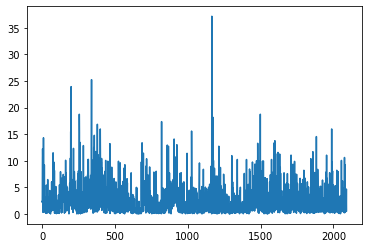

In [14]:
plt.plot(perc_diffs)
mape = np.mean(perc_diffs)
var = np.std(perc_diffs)
print(var)
print(mape)

In [24]:
full_pred = xgb_class.predict(feature_df)
pa_df = compute_price_action(feature_df['Close'])


 
lag = 4
acc = accuracy_score(pa_df[-lag:],full_pred[-(lag+3):-3])
print(acc)
print(feature_df['Close'].tail(lag+1))
print(pa_df[-lag:])
print(full_pred[-(lag+3):-3])
print(full_pred[-14:])

0.25
2022-09-19    19544.129250
2022-09-20    18890.789096
2022-09-21    18547.399760
2022-09-22    19413.551621
2022-09-23    19297.637840
Freq: D, Name: Close, dtype: float64
[0 0 1 0]
[1 1 0 0]
[0 0 0 1 0 1 1 1 1 0 0 1 1 1]


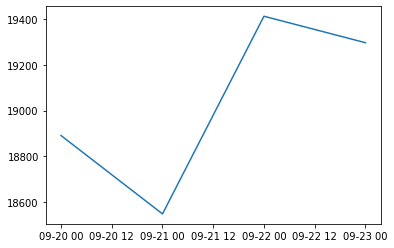

In [25]:
plt.plot(feature_df['Close'].iloc[-lag:])

# Lessons Learned

1. Make ABSOLUTELY SURE that the X's and y's are properly aligned when predicting horizons. This can be a major headache.

2. If you are planning to deploy a small horizon model, ensure that the data sources that act as inputs are regularly updated. If they are not, bake this into the horizon of the model

3. Dont be afraid to play with the number of features. If your model is performing well with many features, it wont perform much worse, and will often perform better with fewer features.

4. Pre-processing features matters. The extra complexity of operations between features is more difficult for the model than if you manually perform feature engineering first

5. Be fully aware of all "levers" that exist for your models performance. This includes horizons (targets), feature amount and type, hyperparameters, curating training data regimes, etc.